- [Import libraries](#import-libraries)
- [Data analysis](#data-analysis)
- [Create image data generators](#create-image-data-generators)
- [Set up the model](#set-up-the-model)
   * [Load pretrained model](#load-pretrained-model)
   * [Create classification model](#create-classification-model)
- [Training](#training)
   * [Training the classification model](#training-the-classification-model)
   * [Fine-tuning](#fine-tuning)
- [Evaluate the final model](#evaluate-the-final-model)

<!-- TOC --><a name="import-libraries"></a>
# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<!-- TOC --><a name="data-analysis"></a>
# Data analysis

In [2]:
# Define data paths

test_dir = "/kaggle/input/cats-and-dogs-image-classification/test"
train_dir = "/kaggle/input/cats-and-dogs-image-classification/train"

In [3]:
# Check size of each dataset

import os

def get_dataset_size(dir, type):
    print(f"Scanning {type} images...")
    size = 0
    for label in os.listdir(dir):
        size += len(os.listdir(os.path.join(dir, label)))
    print(f"Number of {type} images: {size}\n")
    return size

num_test = get_dataset_size(test_dir, "test")
num_train = get_dataset_size(train_dir, "train")

Scanning test images...
Number of test images: 140

Scanning train images...
Number of train images: 557



In [4]:
num_classes = len(os.listdir(train_dir))
print(f"Number of classes: {num_classes}")

Number of classes: 2


- visualizes a few samples from the training dataset for each class
- uses Matplotlib to create a grid of images
- plt.subplots(): Creates a grid 
- picks a random image
- Reads the image using "OpenCV Library"
- converts it to RGB format , for Compatibility with Matplotlib (ex: imshow), or else the colors may appear distorted or inverted.

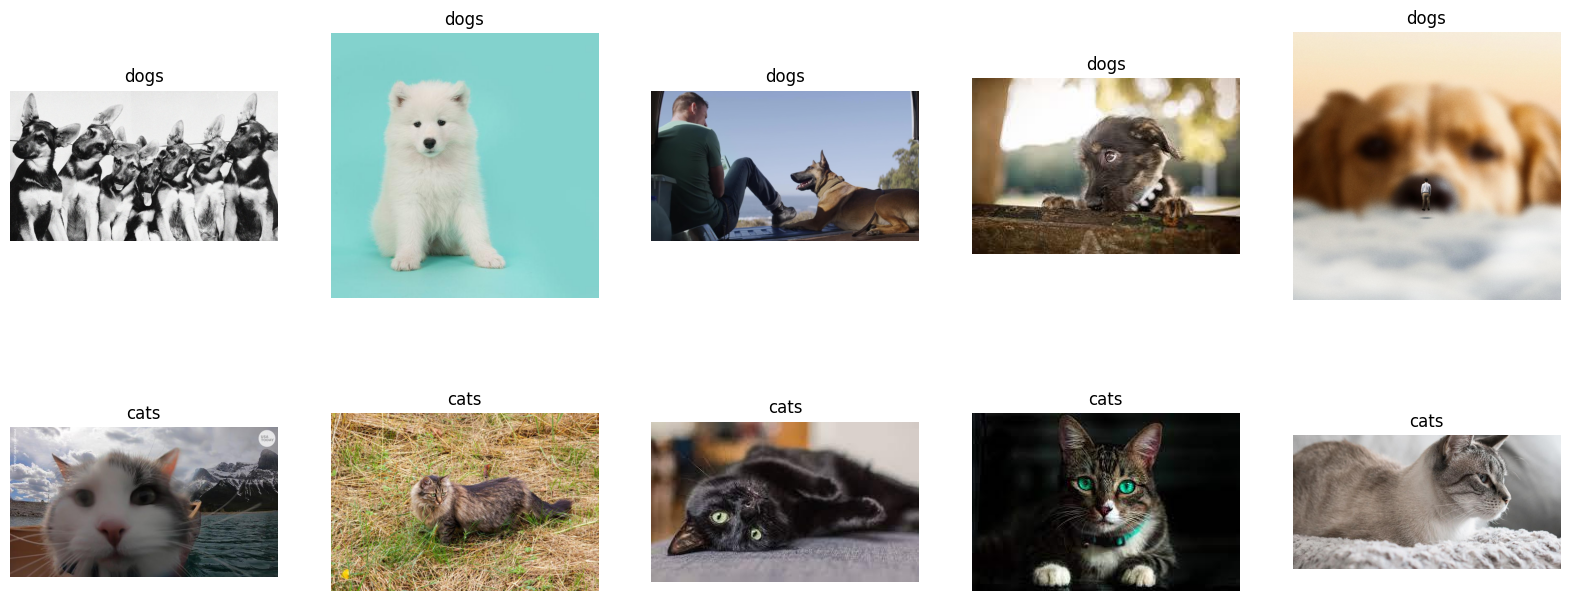

In [5]:
# Let's view a few training samples

import random
import cv2

# imgs to plot per class
m = 5

fig, axs = plt.subplots(nrows=num_classes, ncols=m, figsize=(m*4, num_classes*4))

for i in range(num_classes):

    label = os.listdir(train_dir)[i]
    
    for j in range(m):
        
        # get a random image from the chosen species
        
        img_name = random.choice(os.listdir(os.path.join(train_dir, label)))
        img_path = os.path.join(train_dir, label, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # plot the image
        axs[i][j].imshow(image)
        axs[i][j].set_title(label)
        axs[i][j].axis("off")
        
fig.show()

<!-- TOC --><a name="create-image-data-generators"></a>
# Create image data generators

- "ImageDataGenerator" instance - a class in TensorFlow - do generate different images by flipping the images (ex : horizontal_flip=True) in the dataset during training , creating more diverse training data , so improving the model performance

- (validation_split=0.1) specifies that 10% of the training data will be used as validation , used to evaluate the model's performance .

In [6]:
# Let's create our image preprocessors

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    validation_split=0.1
)

denotes the desired dimensions for the input images

In [7]:
# Let's define the target size

input_size = (224, 224)

- set up three image generators for training, validation, and testing.
- using the Keras ImageDataGenerator class.

- target_size: Resizes images to the specified size.
- batch_size: Number of images in each batch.
- shuffle=True: Shuffles the data. It randomizes the order of the data samples within each batch during training. This randomness helps the model generalize better by preventing it from learning the sequence or orde



In [8]:
# Let's create our image generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
    subset="training"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=False,
    subset="validation"
)

Found 557 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


<!-- TOC --><a name="set-up-the-model"></a>
# Set up the model

<!-- TOC --><a name="load-pretrained-model"></a>
## Load pretrained model

Let's load a Resnet50 model which has been pretrained on the ImageNet dataset

https://www.kaggle.com/code/giggles1/pattern-dogs-and-cats-classifier/edit/run/155718871- Loading VGG19 Model Weights (AKA Parameters)

In [9]:
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

base_model = VGG19(
    include_top = False,
    weights=None  ,
)

# Load the manually downloaded weights
weights_path = "/kaggle/input/vgg19weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model.load_weights(weights_path)

- Model works on layers , like it recieves the image , then another layer performs featre extraction , another reduces the spatial dimensions and complixety , another layer connecting every neuron to make predicitions 

In [10]:
# Let's print out a description of the model layers

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

- Trainable variables in a neural network model are the parameters that the model learns and updates during the training process to minimize the loss function

In [11]:
len(base_model.trainable_variables)

32

<!-- TOC --><a name="create-classification-model"></a>
## Create classification model

Let's add a classification head to this pretrained model

- batch of 32 images where each image has been processed to produce a feature map of size 7x7 with 512 channels

In [12]:
# Before we add the classification head,
# Let's get the output shape of the ResNet (without the classification head)

image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(f"Output shape of feature extractor: {feature_batch.shape}")

Output shape of feature extractor: (32, 7, 7, 512)


- Freezing the feature extractor means that you're preventing the weights of the base model (VGG19) from being updated during training. This step is often done when you have a pre-trained model and want to use its learned representations without modifying them while training a new classification head on top of it.

In [13]:
# Let's freeze the feature extractor

base_model.trainable = False

- This operation collapses each feature map into a single value, resulting in an output shape of (32, 512), which represents 32 samples and 512 features.

In [14]:
# Add a global pooling layer to flatten the output of the feature extractor

from tensorflow.keras.layers import GlobalAveragePooling2D

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


- Great! The addition of the fully connected layer, Dense, will transform the output of the previous layer into predictions for the specific number of classes. Given the output shape of the feature_batch_average as (32, 512), after applying the Dense layer, the shape of prediction_layer_output will be (32, num_classes), where num_classes represents the number of classes in your classification task.

In [15]:
# Add a fully connected layer

from tensorflow.keras.layers import Dense

prediction_layer = Dense(num_classes)
prediction_layer_output = prediction_layer(feature_batch_average)
print(prediction_layer_output.shape)

(32, 2)


- Looks like you've assembled the model with the input layer, pre-processing step, base model (feature extractor), global average pooling layer, and the prediction layer. This model takes inputs of shape input_size + (3,), applies pre-processing, extracts features using the base model, performs global average pooling, and generates predictions using the Dense layer. It seems ready for training and evaluation!

In [16]:
# Now let's combine all the layers into a complete model

inputs = tf.keras.Input(shape=input_size + (3,))
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [17]:
# Let's explore the model's layers

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026  

In [18]:
len(model.trainable_variables)

2

<!-- TOC --><a name="training"></a>
# Training

<!-- TOC --><a name="training-the-classification-model"></a>
## Training the classification model

- compiled the model using the Adam optimizer with a learning rate of 0.0001 , Adam computes adaptive learning rates for each parameter

In [19]:
# Let's compile the model


base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
initial_epochs = 80

- calculating and printing the initial loss and accuracy metrics before the model training begins

In [21]:
loss0, accuracy0 = model.evaluate(val_generator)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 14s 2s/step - loss: 4.2567 - accuracy: 0.5079
initial loss: 4.26
initial accuracy: 0.51


In [22]:
# Let's fit the model
# Remember, we are only training the classification head

history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator
)

Epoch 1/80
18/18 [==============================] - 15s 692ms/step - loss: 4.9243 - accuracy: 0.5781 - val_loss: 4.0775 - val_accuracy: 0.5000
Epoch 2/80
18/18 [==============================] - 6s 314ms/step - loss: 4.1337 - accuracy: 0.5655 - val_loss: 3.7193 - val_accuracy: 0.4921
Epoch 3/80
18/18 [==============================] - 6s 313ms/step - loss: 4.0948 - accuracy: 0.5494 - val_loss: 3.4546 - val_accuracy: 0.5000
Epoch 4/80
18/18 [==============================] - 6s 325ms/step - loss: 3.6900 - accuracy: 0.5404 - val_loss: 3.7211 - val_accuracy: 0.5317
Epoch 5/80
18/18 [==============================] - 6s 328ms/step - loss: 3.4948 - accuracy: 0.5296 - val_loss: 3.7479 - val_accuracy: 0.5476
Epoch 6/80
18/18 [==============================] - 6s 335ms/step - loss: 3.4133 - accuracy: 0.5386 - val_loss: 3.5820 - val_accuracy: 0.5556
Epoch 7/80
18/18 [==============================] - 6s 309ms/step - loss: 3.0725 - accuracy: 0.5440 - val_loss: 3.5775 - val_accuracy: 0.5556
Epoch

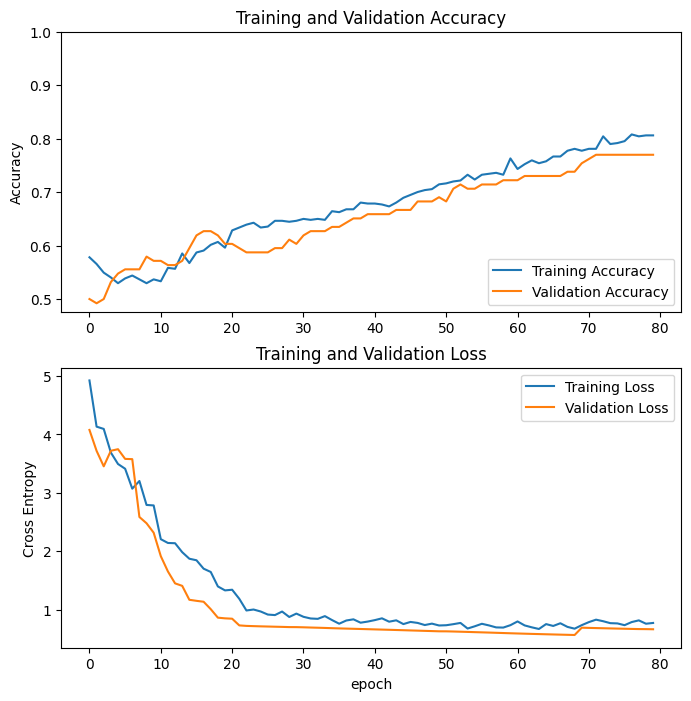

In [23]:
# Let's plot the results of the training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<!-- TOC --><a name="fine-tuning"></a>
## Fine-tuning

Now that we've trained the classification head, let's train some of the top layers to greatly improve the performance of the model.

- will unfreeze the layers in the base model, allowing their weights to be updated during training

In [24]:
base_model.trainable = True

- freezing all layers before the 18th layer by setting their trainable attribute to False. This is a common technique in transfer learning where you freeze initial layers (which capture more general features) and fine-tune deeper layers to adapt to the specific task or dataset.

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  22


- The model.compile() function is used to configure the model for training

In [26]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026  


An increase in the number of trainable parameters typically occurs when you "unfreeze" some layers of a pre-trained model for fine-tuning. When you set certain layers as trainable, the model can adjust the weights in those layers during training, which leads to an increase in the number of parameters that can be modified.

In [28]:
len(model.trainable_variables)

8

 prevent overfitting during training

In [29]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

In [30]:
# # Let's fine tune the model

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[earlystopping]
)

Epoch 80/90
18/18 [==============================] - 10s 359ms/step - loss: 0.5752 - accuracy: 0.8941 - val_loss: 0.4593 - val_accuracy: 0.9127
Epoch 81/90
18/18 [==============================] - 6s 332ms/step - loss: 0.1847 - accuracy: 0.9605 - val_loss: 0.3768 - val_accuracy: 0.9286
Epoch 82/90
18/18 [==============================] - 6s 316ms/step - loss: 0.0809 - accuracy: 0.9838 - val_loss: 0.3788 - val_accuracy: 0.8889
Epoch 83/90
18/18 [==============================] - 6s 315ms/step - loss: 0.0416 - accuracy: 0.9928 - val_loss: 0.3295 - val_accuracy: 0.9365
Epoch 84/90
18/18 [==============================] - 6s 312ms/step - loss: 0.0274 - accuracy: 0.9946 - val_loss: 0.2953 - val_accuracy: 0.9286
Epoch 85/90
18/18 [==============================] - 6s 315ms/step - loss: 0.0122 - accuracy: 0.9982 - val_loss: 0.3894 - val_accuracy: 0.8889
Epoch 86/90
18/18 [==============================] - 6s 320ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2868 - val_accuracy: 0.920

Wow! That really boosted performance!

In [31]:
# Update the accuracy and loss

acc = []
val_acc = []
loss = []
val_loss = []

# Then, in your loop or code block:
acc.append(history_fine.history['accuracy'])
val_acc.append(history_fine.history['val_accuracy'])
loss.append(history_fine.history['loss'])
val_loss.append(history_fine.history['val_loss'])



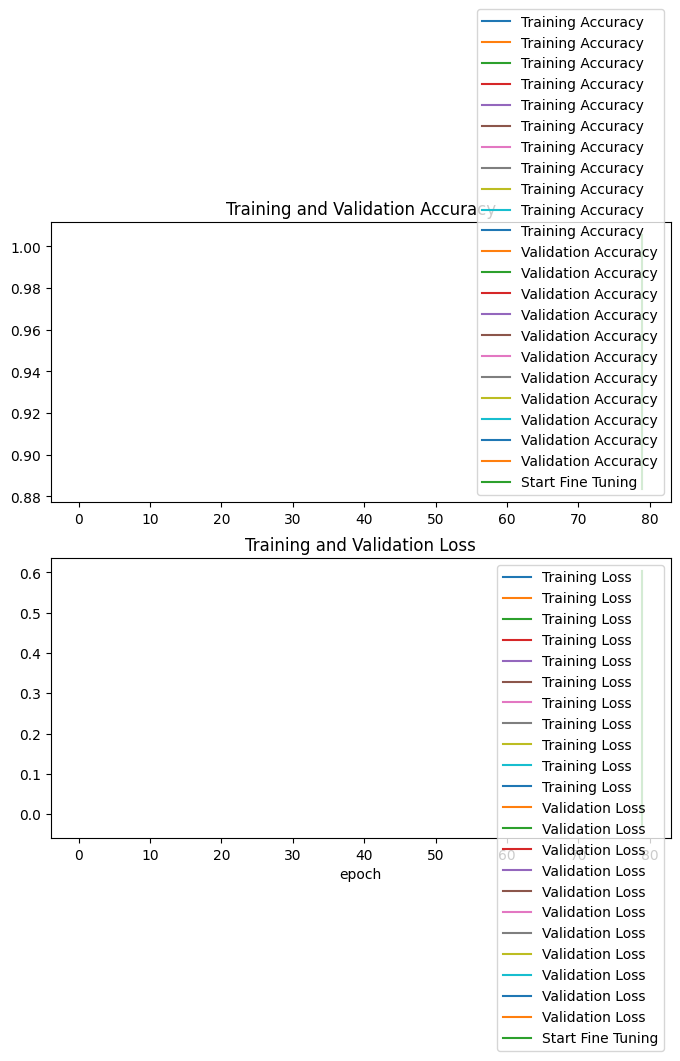

In [32]:
# Plot the results!

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<!-- TOC --><a name="evaluate-the-final-model"></a>
# Evaluate the final model

This code will print the accuracy percentage after evaluating the model on the test data.







In [33]:
loss, acc = model.evaluate(test_generator, verbose=False)
print(f"Validation accuracy: {acc*100}%")

Validation accuracy: 100.0%


1/1 [==============================] - 1s 962ms/step


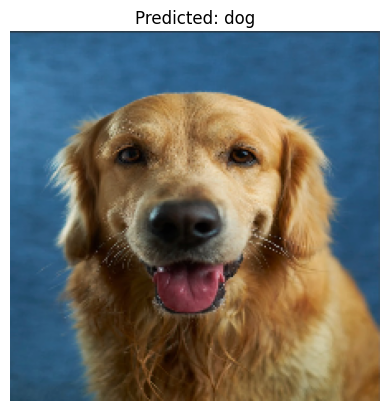

In [34]:
from tensorflow.keras.preprocessing import image as keras_image

def predict_image_class(model, image_path, target_size):
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict the class of the image
    predictions = model.predict(img_array)
    predicted_class = "cat" if predictions[0][0] > 0.5 else "dog"

    # Display the prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

# Usage example:
# Replace 'model' with the name of your trained model variable and specify the image path
image_path = '/kaggle/input/thisdog/WhatsApp Image 2023-12-20 at 03.25.04_bad587c4.jpg'
target_size = (224, 224)  # Same target size used during model training
predict_image_class(model, image_path, target_size)